# Data Fusion: Radar and Optical Systems
In this example data from two sources will be combined. This example will use data from RISR that was retreved through Madrigal and Optical Mesosphere and Thermosphere Imager (OMTI) all-sky imager[Shiokawa et. al. 1999].

In [1]:
%matplotlib inline
import matplotlib
from __future__ import division,print_function
import logging
import pdb
import os
import matplotlib.pyplot as plt
import numpy as np
# Import Geodata modules
from GeoData import GeoData
from GeoData.plotting import slice2DGD,plotbeamposGD,insertinfo,contourGD
from GeoData.plottingmayavi import plot3Dslice
from GeoData import utilityfuncs
# Use Mayavi for 3-D plots
from mayavi import mlab

## Read in Data
Using GeoData we first have to get the data into the proper format. This example uses RISR data retrived from Madrigal, which can be read in by using the readMat_hdf5 function. This will create the GeoData instance labeled as risr. The OMTI file is read in using readOMTI function, which creates the GeoData instance named omti. Lastly to get linearly scaled electron density we use the method changedata from GeoData.   

In [2]:
def revpower(x1,x2):
    return x2**x1

omtiName = 'OMTIdata.h5'
risrName = 'ran120219.004.hdf5'
isrparams=['nel']
#creating GeoData objects of the 2 files, given a specific parameter

omti = GeoData.GeoData(utilityfuncs.readOMTI,(omtiName, ['optical']))


risr = GeoData.GeoData(utilityfuncs.readMad_hdf5,(risrName, isrparams))
#converting logarthmic electron density (nel) array into electron density (ne) array
risr.changedata('nel','ne',revpower,[10.0])

/Users/swoboj/Documents/Python/GeoDataPython/GeoData/utilityfuncs.py:110: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  data[p] = DataFrame(data=filt_data[p].reshape((dataloc.shape[0],uniq_times.shape[0]),order='F'),


## Time Register Data
The next step once the data has been read into memory is registering the data in time and space. The method timeregister will find all of the instances where the data from risr instance overlap with data from omti. The data is then reduced to only the instances where there are common times between omti and risr. The other times are tossed out so when we interpolate we don't have to interpolate data we have no use for.

In [3]:
reglistlist = omti.timeregister(risr)
keepomti = [i  for i in range(len(reglistlist)) if len(reglistlist[i])>0]
reglist = list(set(np.concatenate(reglistlist)))

# Reduce the size of the GeoData Instances.
risr_classred =risr.timeslice(reglist,'Array')
omti = omti.timeslice(keepomti,'Array')
# Re-register in time 
reglistfinal = omti.timeregister(risr_classred)

## Interpolation
The reduced data is now interpolated into a common Cartesian frame. The method interpolate performs changes the coordinate systems, and interpolates the data and changes the instance of the class to the new coordinate system. For the omti instance we only interpolate in two dimensions as we only have azimuth and elevation info. We pick an altitude to interpolate over and file any gaps with NaNs. The risr data is in three dimensions as we have range information for it. Currently the fastest method of interpolation is the linear interpolation method.

In [4]:
xvec,yvec,zvec = [np.linspace(-100.0,500.0,25),np.linspace(0.0,600.0,25),np.linspace(100.0,500.0,25)]
x,y,z = np.meshgrid(xvec,yvec,zvec)
x2d,y2d = np.meshgrid(xvec,yvec)
new_coords =np.column_stack((x.ravel(),y.ravel(),z.ravel()))
new_coords2 = np.column_stack((x2d.ravel(),y2d.ravel(),140.0*np.ones(y2d.size)))
#%% interpolate risr data
risr_classred.interpolate(new_coords, newcoordname='Cartesian', method='linear', fill_value=np.nan)
#%% interpolate omti data
omti.interpolate(new_coords2, newcoordname='Cartesian', twodinterp = True,method='linear', fill_value=np.nan)

Interpolating ne
	Interpolating time instance 0 of 25 for parameter ne
	Interpolating time instance 1 of 25 for parameter ne
	Interpolating time instance 2 of 25 for parameter ne
	Interpolating time instance 3 of 25 for parameter ne
	Interpolating time instance 4 of 25 for parameter ne
	Interpolating time instance 5 of 25 for parameter ne
	Interpolating time instance 6 of 25 for parameter ne
	Interpolating time instance 7 of 25 for parameter ne
	Interpolating time instance 8 of 25 for parameter ne
	Interpolating time instance 9 of 25 for parameter ne
	Interpolating time instance 10 of 25 for parameter ne
	Interpolating time instance 11 of 25 for parameter ne
	Interpolating time instance 12 of 25 for parameter ne
	Interpolating time instance 13 of 25 for parameter ne
	Interpolating time instance 14 of 25 for parameter ne
	Interpolating time instance 15 of 25 for parameter ne
	Interpolating time instance 16 of 25 for parameter ne
	Interpolating time instance 17 of 25 for parameter ne
	In

## Plotting
We plot the data number of different ways. First we use mayavi to create a 3-D reconstruction of the radar data with the OMTI data as a slice under it. Then we take a single altitude slice and plot it in the next subplot. The subplot on the bottom left shows the OMTI but with altitude slice of radar data over it as a contour plot. Lastly the bottom right hand plot shows the beam positions of the radar. Each of these plots have their own plotting function and can be used if you're using GeoData, assuming the proper coordinate systems are being used. For the most part it is required to first interpolate the data into a Cartisian frame as this is a common frame to help understand the physical processes taking place.

No handlers could be found for logger "mayavi.core.common"
/Users/swoboj/anaconda/envs/geodata/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


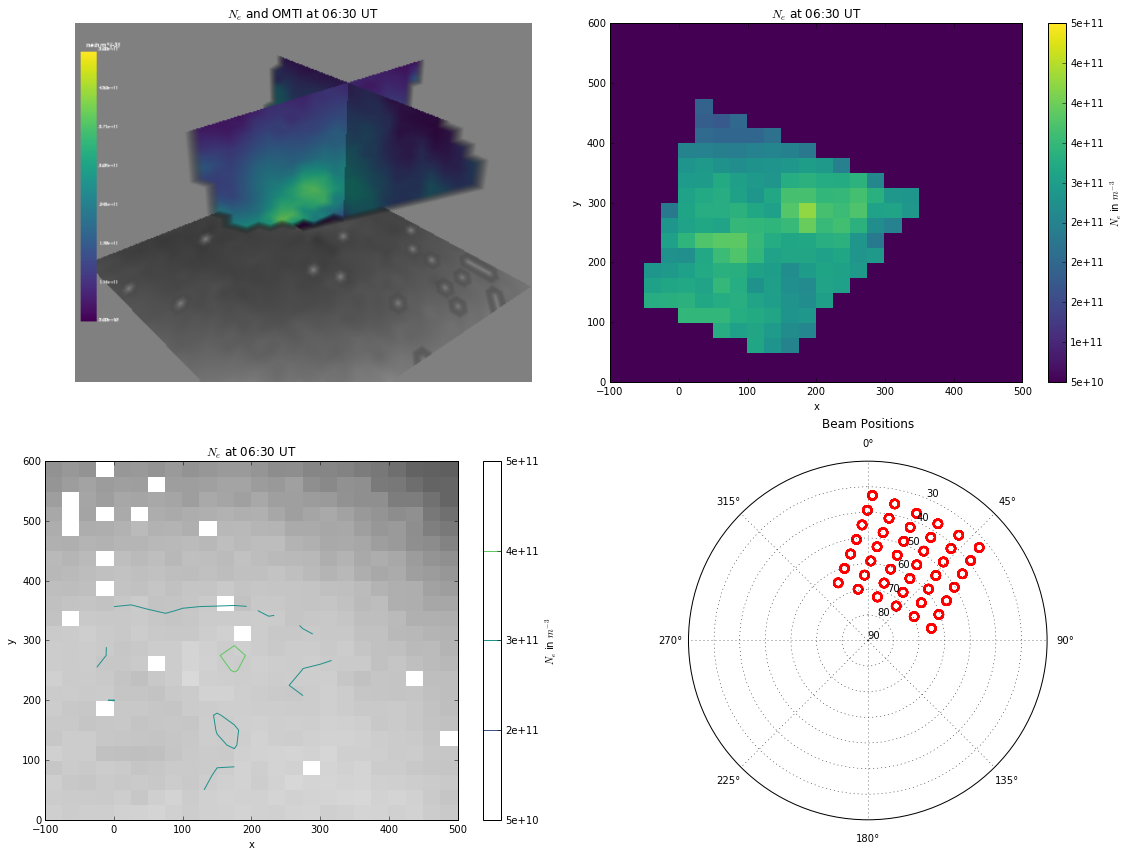

In [5]:
omtitime = 14
ilist = reglistfinal[omtitime]
risrtime =  ilist[0]
omtislices =  [[],[],[140]]
risrslices = [[100],[300],[]]
vbounds = [[200,800],[5e10,5e11]]
try:
    mfig = mlab.figure(fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
    surflist1 = plot3Dslice(omti, omtislices, vbounds[0], time=omtitime, cmap='gray', 
                            gkey='optical', fig=mfig)
    arr = plot3Dslice(risr_classred, risrslices, vbounds[1], time=risrtime, cmap='viridis', 
                      gkey='ne', fig=mfig, units='m^{-3}', colorbar=True, view=[50,60], outimage=True)
    titlestr1 = '$N_e$ and OMTI at $thm'
    newtitle = insertinfo(titlestr1, '', risr_classred.times[risrtime, 0], risr_classred.times[risrtime, 1])
except Exception as e:
    logging.error('trouble with 3D plot  {}'.format(e))

(figmplf, [[ax1,ax2],[ax3,ax4]]) = plt.subplots(2, 2,figsize=(16, 12), facecolor='w')

try:
    ax1.imshow(arr)
    ax1.set_title(newtitle)
    ax1.axis('off')
except:
    pass

(slice2,cbar2) = slice2DGD(risr_classred,'z',300,vbounds[1],title='$N_e$ at $thm',
            time = risrtime,gkey = 'ne',fig=figmplf,ax=ax2)
cbar2.set_label('$N_e$ in $m^{-3}$')

(slice3,cbar3) = slice2DGD(omti,'z',omtislices[-1][0],vbounds[0],title='OMTI at $thm',
            time = omtitime,cmap='Greys',gkey = 'optical',fig=figmplf,ax=ax3,cbar=False)
plt.hold(True)

(slice4,cbar4) = contourGD(risr_classred,'z',300,vbounds[1],title='$N_e$ at $thm',
            time = risrtime,gkey = 'ne',fig=figmplf,ax=ax3)
cbar4.set_label('$N_e$ in $m^{-3}$')
ax4 = plt.subplot(2,2,4,polar=True)
bmpos = plotbeamposGD(risr,fig=figmplf,ax=ax4)
plt.tight_layout()

## References
Shiokawa, K., Y. Katoh, M. Satoh, M. K. Ejiri, T. Ogawa, T. Nakamura, T. Tsuda, and R. H. Wiens (1999), Development of Optical Mesosphere
Thermosphere Imagers (OMTI), Earth Planets Space, 51, 887–896, doi:10.5636/eps.51.887.

Ramachandran, P. and Varoquaux, G., `Mayavi: 3D Visualization of Scientific Data` IEEE Computing in Science & Engineering, 13 (2), pp. 40-51 (2011)